In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from itertools import product
from typing import Union
from tqdm import tqdm_notebook
import pylab
from statsmodels.stats.diagnostic import acorr_ljungbox

pd.options.mode.chained_assignment = None

In [ ]:
# link to the file: https://www.dropbox.com/scl/fi/ul5nt2b92wz2cwx0qw6ks/data_shipments.csv?rlkey=0uby9imeorpgjueoi7kyqvgi5&st=uxgiz1d4&dl=0
!wget -O data.csv https://www.dropbox.com/scl/fi/ul5nt2b92wz2cwx0qw6ks/data_shipments.csv?rlkey=0uby9imeorpgjueoi7kyqvgi5&st=uxgiz1d4&dl=0

--2024-06-15 17:46:43--  https://www.dropbox.com/scl/fi/ul5nt2b92wz2cwx0qw6ks/data_shipments.csv?rlkey=0uby9imeorpgjueoi7kyqvgi5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9d905e0c7798a69a48d9d8aa2b.dl.dropboxusercontent.com/cd/0/inline/CU7Sz38MFAMz6-uBuvZNbe4bTJzmqToYj8KXWLknshzeAg2b2q81sUfT2wdTWlo00qNqr_LJ16Rn0qBqjKSLOL2XmsOgXl6OGvayhPb4OIfUDvmlGSnlo3J0DDlzE9aGN-kWzgIjgw4i0-mBJqDEfmhE/file# [following]
--2024-06-15 17:46:43--  https://uc9d905e0c7798a69a48d9d8aa2b.dl.dropboxusercontent.com/cd/0/inline/CU7Sz38MFAMz6-uBuvZNbe4bTJzmqToYj8KXWLknshzeAg2b2q81sUfT2wdTWlo00qNqr_LJ16Rn0qBqjKSLOL2XmsOgXl6OGvayhPb4OIfUDvmlGSnlo3J0DDlzE9aGN-kWzgIjgw4i0-mBJqDEfmhE/file
Resolving uc9d905e0c7798a69a48d9d8aa2b.dl.dropboxusercontent.com (uc9d905e0c7798a69a48d9d8aa2b.dl.dropboxusercontent.com)... 162.125.3.15, 

In [ ]:
# it will be needed later for error-rate calculations:
def mape(y_true, y_pred):
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
df = pd.read_csv("data.csv")
df.head()
# df.info()

,time,value
0,199201,5618
1,199202,7205
2,199203,7446
3,199204,7420
4,199205,8076


In [ ]:
# Firstly, we need to convert the first columns values to date:
df['time'] = pd.to_datetime(df['time'], format="%Y%m")
df.head()

,time,value
0,1992-01-01,5618
1,1992-02-01,7205
2,1992-03-01,7446
3,1992-04-01,7420
4,1992-05-01,8076


Text(0, 0.5, 'Vehicle shipments, $ millions')

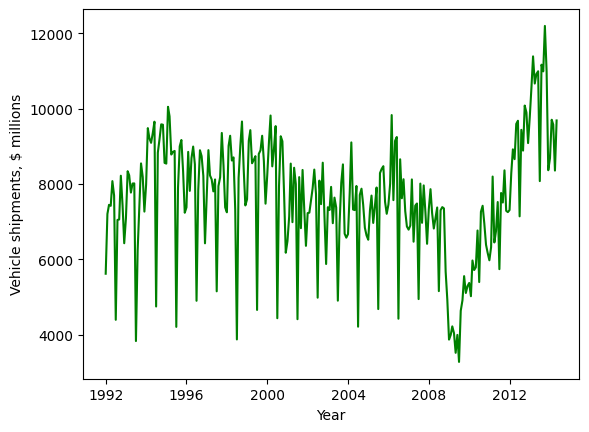

In [ ]:
fig, ax = plt.subplots()
ax.plot(df['time'], df['value'], 'g-')
ax.set_xlabel('Year')
ax.set_ylabel('Vehicle shipments, $ millions')
# looks kinda odd, so it is a better idea to check only a couple of years,
# since it will also helps us to detect potential seasonalities.

# Overall we can say that, apart from period of 2008 financial crisis,
# there was more like a stationary ts,
# but after it the overall growing trend begun.

Text(0, 0.5, 'Vehicle shipments, $ millions')

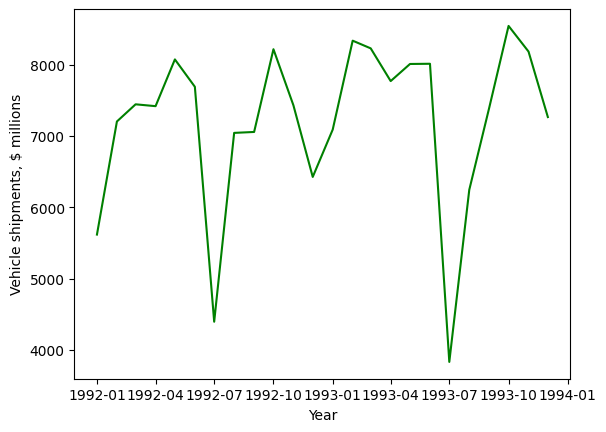

In [ ]:
# For experiment we'll take data from first and last two years
# *2014 is only half-presented
fig, ax = plt.subplots()
ax.plot(df['time'].values[:24], df['value'].values[:24], 'g-')
ax.set_xlabel('Year')
ax.set_ylabel('Vehicle shipments, $ millions')

Text(0, 0.5, 'Residuals')

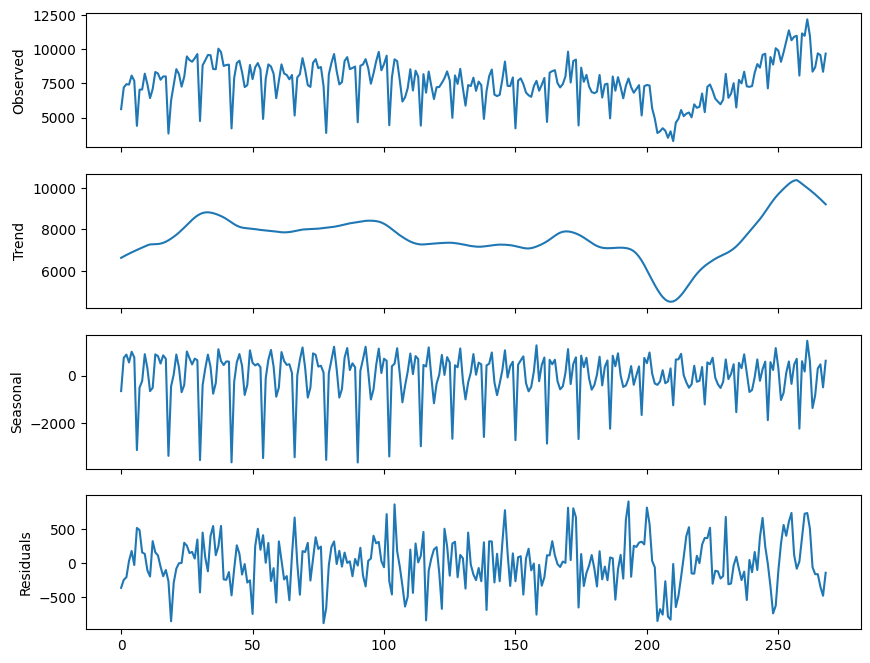

In [ ]:
decomposition = STL(df['value'], period=12).fit()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1,
sharex=True, figsize=(10,8))
ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')
# reasons for the existence of periodic patterns:
# 1) There some periods when the demand on a new car is lower than the others,
# for example, in summertime, when majority of people are on vacation and
# don't want to spend their free excellent time at the dealership, so the demand
# on cars is significantly lower :)
# 2) In Jan we meet Xmas and New Year holidays consequences, so some part of this
# period people tend to spend time with their families. Once again, the demand
# is lower than other months.

# also, since we know we have the seasonality in dataset,
# the primary baseline-method we will use to compare the accuracy
# will be the naive-seasonal one.
# Additionally, just out of a curiosity we will compare it with
# the last-known value method.

In [ ]:
# now let's determine the oder of integration, for that we will use ADF-test:
ADF_result = adfuller(df['value'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
# well, p-value is close to 0.05, so the theory of having a close-to-stationary
# process is quite trustworthy, but, still, the differencing is required:

# firstly, we will apply simple differencing and after that the seasonal one.
# We'll do a combination of them both to see,
# which one will be better in terms of stationarity.

# 1) simple differencing only:
df_diff = np.diff(df['value'], n=1)
ADF_result = adfuller(df_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

# 2) seasonal differencing only:
df_diff_seasonal = np.diff(df['value'], n=12)
ADF_result = adfuller(df_diff_seasonal)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

# as we can see from the results (in both cases differencing was applied to
# different series) that the problem with not being stationary is mostly due to
# large seasonal fluctuations, rather the overall trend.
# So there is no need in simple differencing, we can just apply seasonal one.

# in total we have:
# order of integration (global) - 0;
# order of integration (seasonal) - 1;

ADF Statistic: -2.654639251341716
p-value: 0.08222189585453338
ADF Statistic: -3.8877016862523064
p-value: 0.002127243466315599
ADF Statistic: -21.163198215445107
p-value: 0.0


Text(0, 0.5, 'Vehicle shipments, $ millions')

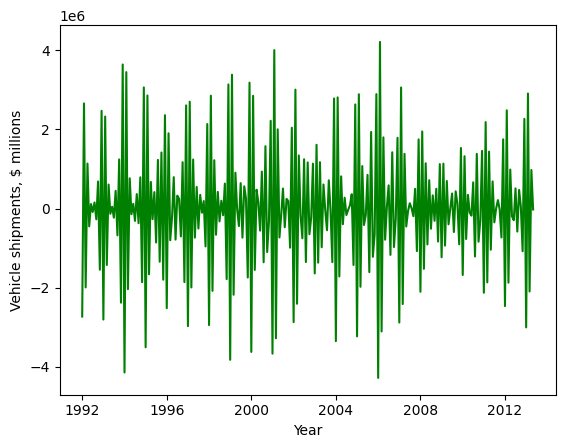

In [ ]:
# in order to be absolutely sure we can plot our differenced series:
fig, ax = plt.subplots()
ax.plot(df['time'].values[:257], df_diff_seasonal, 'g-')
ax.set_xlabel('Year')
ax.set_ylabel('Vehicle shipments, $ millions')
# there is some misalignment in date, but it doesn't matter for now.

In [ ]:
# now it is time to find the best model to make futher predictions:
# first, we'll do a train-test-split as alwasy (2013 and 2014 will go to test):

# we will use the source dataframe since SARIMAX can handle itself
# and apply the differencing to a series if we put it into a model params:
train = df[:-17]
test = df[-17:]
print(train.shape, test.shape)
display(test)

(252, 2) (17, 2)


,time,value
252,2013-01-01,9789
253,2013-02-01,10591
254,2013-03-01,11387
255,2013-04-01,10666
256,2013-05-01,10920
257,2013-06-01,10992
258,2013-07-01,8076
259,2013-08-01,11166
260,2013-09-01,10989
261,2013-10-01,12195


In [ ]:
# optimized SARIMAX function:
# AIC:
def optimize_ARMA(endog, order_list):
  results = []
  for order in tqdm_notebook(order_list):
    try:
      model = SARIMAX(endog,
                      order=(order[0], 0, order[1]),
                      seasonal_order=(order[2], 1, order[3], 12),
                      simple_differencing=False).fit(disp=False)
    except:
      continue
    aic = model.aic
    results.append([order, aic])
  result_df = pd.DataFrame(results)
  result_df.columns = ['(p,q,P,Q)', 'AIC']
  result_df = result_df.sort_values(by='AIC',
                                    ascending=True).reset_index(drop=True)
  return result_df

In [ ]:
# Defining range for p (P) and q (Q) -- [0..3]:
# d = 0, D = 1
p_values = range(0, 4, 1)
q_values = range(0, 4, 1)
P_values = range(0, 4, 1)
Q_values = range(0, 4, 1)
# cartesian product for 4 sets:
order_list = list(product(p_values, q_values, P_values, Q_values))
print(order_list)

[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 0, 3), (0, 0, 1, 0), (0, 0, 1, 1), (0, 0, 1, 2), (0, 0, 1, 3), (0, 0, 2, 0), (0, 0, 2, 1), (0, 0, 2, 2), (0, 0, 2, 3), (0, 0, 3, 0), (0, 0, 3, 1), (0, 0, 3, 2), (0, 0, 3, 3), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 0, 2), (0, 1, 0, 3), (0, 1, 1, 0), (0, 1, 1, 1), (0, 1, 1, 2), (0, 1, 1, 3), (0, 1, 2, 0), (0, 1, 2, 1), (0, 1, 2, 2), (0, 1, 2, 3), (0, 1, 3, 0), (0, 1, 3, 1), (0, 1, 3, 2), (0, 1, 3, 3), (0, 2, 0, 0), (0, 2, 0, 1), (0, 2, 0, 2), (0, 2, 0, 3), (0, 2, 1, 0), (0, 2, 1, 1), (0, 2, 1, 2), (0, 2, 1, 3), (0, 2, 2, 0), (0, 2, 2, 1), (0, 2, 2, 2), (0, 2, 2, 3), (0, 2, 3, 0), (0, 2, 3, 1), (0, 2, 3, 2), (0, 2, 3, 3), (0, 3, 0, 0), (0, 3, 0, 1), (0, 3, 0, 2), (0, 3, 0, 3), (0, 3, 1, 0), (0, 3, 1, 1), (0, 3, 1, 2), (0, 3, 1, 3), (0, 3, 2, 0), (0, 3, 2, 1), (0, 3, 2, 2), (0, 3, 2, 3), (0, 3, 3, 0), (0, 3, 3, 1), (0, 3, 3, 2), (0, 3, 3, 3), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 0, 2), (1, 0, 0, 3), (1, 0, 1, 0), (1, 0, 1, 1), (1, 0, 1, 2), (1, 0

In [ ]:
# choosing the best model:
result_df = optimize_ARMA(train["value"], order_list)
display(result_df)
# so, the best model so far is the one with the following params:
# Global part:
# p = 0
# d = 0
# q = 1
# Seasonal part:
# P = 1
# D = 1
# Q = 1
# m = 12

# wow, it actually took quite a while :)

# it is actually kinda odd that for overall trend we have MA(1), but ok.
# the gap between top-2 models is insane, actually, i think i can even explain.
# the overall trend of shipments, especially, including 2008 crisis is quite
# random-like, so, yeah, we have some growth in our dataset, but the downfalls
# are also presented here.
# It would be better to check the model with other params, not only top-1,
# since it really concerns me (that big difference).

<ipython-input-23-0d777528b290>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

,"(p,q,P,Q)",AIC
0,"(0, 1, 1, 1)",131.517919
1,"(3, 1, 0, 1)",3791.732162
2,"(3, 1, 0, 3)",3792.426595
3,"(3, 2, 0, 1)",3793.612674
4,"(3, 1, 1, 1)",3793.680045
...,...,...
251,"(0, 0, 0, 2)",4055.398186
252,"(0, 0, 2, 0)",4060.269193
253,"(0, 0, 0, 0)",4071.327966
254,"(0, 0, 1, 0)",4071.532337


In [82]:
window_size = 1
pred_SARIMA = []
df_new = df['value']
for i in range(len(train),
               len(train) + len(test),
               window_size):
  model = SARIMAX(df_new[:i],
                  # order=(0,0,1),
                  # seasonal_order=(1,1,1,12),
                  # order=(3,0,1),
                  # seasonal_order=(0,1,1,12),
                  order=(3,0,1),
                  seasonal_order=(0,1,3,12),
                  simple_differencing=False)
  res = model.fit(disp=False)
  predictions = res.get_prediction(0, i + window_size - 1)
  oos_pred = predictions.predicted_mean.iloc[-window_size:]
  pred_SARIMA.extend(oos_pred)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[-8.63183468e+07 -1.38975726e+03 -1.99471659e+03 -1.35746356e+03
 -1.10854669e+03 -1.13981355e+03 -4.49961304e+02 -1.85181264e+03
 -1.41300245e+03 -1.37226977e+03 -3.93443913e+02  9.74238525e+02
  6.90087221e+02  5.34975974e+02  1.57752997e+03  1.73147532e+03
  6.02139541e+02]


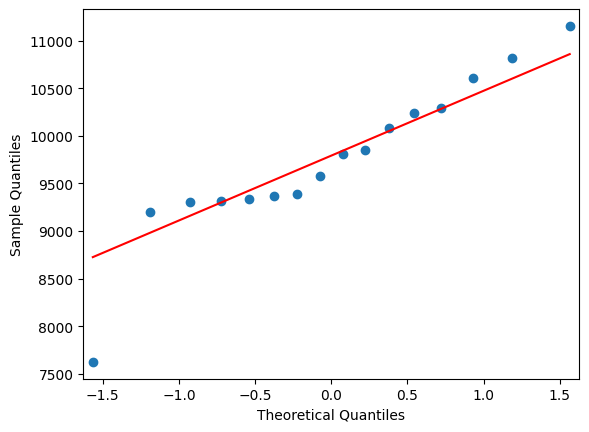

In [68]:
# !SARIMA(0,0,1)(1,1,1)12:

# q-q plot:
residuals = pred_SARIMA - test['value'].values
print(residuals)
sm.qqplot(np.array(pred_SARIMA[1:]), line='q')
pylab.show()
# we can see that there is a slight offset for each value from line,
# but still they are pretty close to it (y = x).

# before moving on to the next stage there is one thing worth mentioning:
# for some reason the first value in predicitons (and it can be seen
# as the scale of the first value in residuals array in comparison to all others)
# is significantly larger than the others.
# i checked for potential errors in code and couldn't find the reasoning for that.
# Logically, the params for the model, especially the global part of it,
# and data from dataset itself wouldn't lead to that scale of an error.

# So, in order to further analyse the predictions, i suggest to skip Jan-2013
# for all methods used, but this artifact is quite interesting.

[ -768.54105152  -816.71518214  -562.96632382  -220.96384938
  -102.73194641   160.48197513   745.75682828  -742.05756705
  -577.74709129 -1075.24623747   193.29677294  1996.91788906
   860.75058382  -315.48395828   530.23278172   833.29217952
  -610.9806538 ]


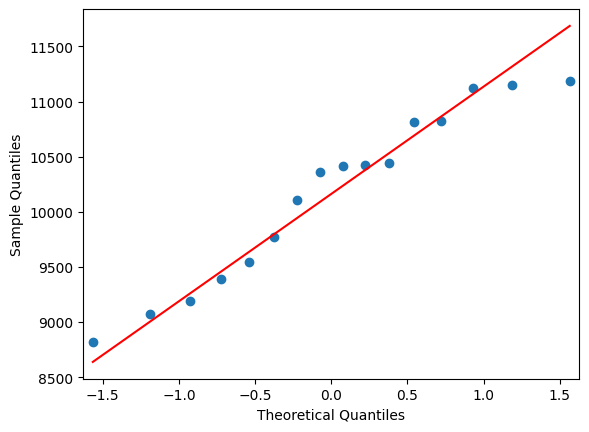

In [73]:
# !SARIMA(3,0,1)(0,1,1)12:

# q-q plot:
residuals = pred_SARIMA - test['value'].values
print(residuals)
sm.qqplot(np.array(pred_SARIMA[1:]), line='q')
pylab.show()

[-781.72334425 -678.21853195 -448.91668427 -387.44711822  -91.29347159
   52.51130978  476.18971742 -757.7954623  -648.38549065 -904.57571302
   94.15037018 1923.36134806  834.57120272  -96.71422024  370.14212717
  969.26792025 -496.04825637]


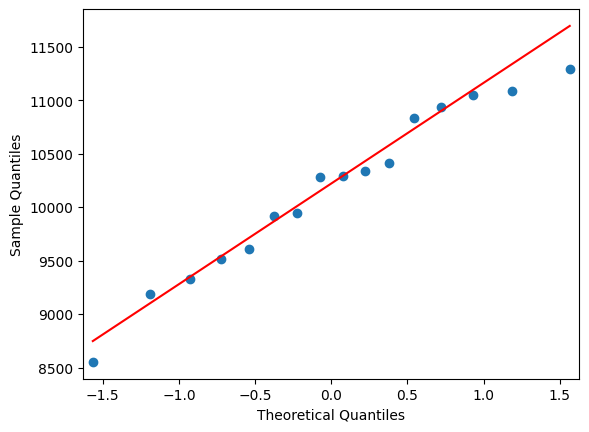

In [83]:
# !SARIMA(3,0,1)(0,1,3)12:

# q-q plot:
residuals = pred_SARIMA - test['value'].values
print(residuals)
sm.qqplot(np.array(pred_SARIMA[1:]), line='q')
pylab.show()

In [79]:
# !SARIMA(0,0,1)(1,1,1)12:
# Ljung-Box test on the first 16 lags only, since the test size is 17:
acorr_ljungbox(pred_SARIMA, lags=16)
# as we can see from here all p-values are greater than 0.05,
# thus, we accept the null hypothesis and
# conclude that the residuals are independent (uncorrelated).

,lb_stat,lb_pvalue
1,0.000272,0.986843
2,0.001435,0.999283
3,0.004239,0.999927
4,0.009614,0.999988
5,0.018711,0.999997
6,0.032966,0.999999
7,0.054349,1.000000
8,0.085391,1.000000
9,0.129630,1.000000
10,0.192035,1.000000


In [75]:
# !SARIMA(3,0,1)(0,1,1)12:
# Ljung-Box test on the first 16 lags only, since the test size is 17:
acorr_ljungbox(pred_SARIMA, lags=16)
# as we can see from here all p-values are greater than 0.05,
# thus, we accept the null hypothesis and
# conclude that the residuals are independent (uncorrelated).

,lb_stat,lb_pvalue
1,1.269350,0.259889
2,1.277265,0.528014
3,1.380650,0.710077
4,2.820259,0.588341
5,2.878929,0.718645
6,3.376899,0.760269
7,3.383614,0.847395
8,4.195557,0.839063
9,4.674474,0.861712
10,5.714441,0.838657


In [84]:
# !SARIMA(3,0,1)(0,1,3)12:
# Ljung-Box test on the first 16 lags only, since the test size is 17:
acorr_ljungbox(pred_SARIMA, lags=16)
# as we can see from here all p-values are greater than 0.05,
# thus, we accept the null hypothesis and
# conclude that the residuals are independent (uncorrelated).

,lb_stat,lb_pvalue
1,0.668362,0.413623
2,0.737216,0.691696
3,1.019491,0.796536
4,2.903744,0.574061
5,2.930939,0.710632
6,3.856009,0.696155
7,3.863936,0.795309
8,4.041225,0.853385
9,4.428662,0.881006
10,4.984860,0.892187


In [70]:
# !SARIMA(0,0,1)(1,1,1)12:
# Now let's calculate everything we need with baseline methods:

# naive seasonal method (since we have only one half of 2014 we'll do one trick):
pred_seasonal = np.zeros(len(test['value'].values))
pred_seasonal[:12] = train['value'].values[-12:]
pred_seasonal[-5:] = train['value'].values[-12:-7]
# There and for all other methods we'll skip the Jan-2013, because of a strange
# error when SARIMAX function was used.
seasonal_error = mape(test['value'].values[1:], pred_seasonal[1:])

# last known value method:
pred_last_known = test['value']
pred_last_known = np.roll(pred_last_known, 1)
pred_last_known[0] = train['value'].values[-1]
next_value_error = mape(test['value'].values[1:], pred_last_known[1:])

# SARIMAX method (error calculations only):
sarima_error = mape(test['value'].values[1:], pred_SARIMA[1:])

# printing the error rates:
print("Naive seasonal MAPE:", seasonal_error)
print("Last-known value MAPE:", next_value_error)
print("SARIMA-model appliance MAPE:", sarima_error)

# the best perfomance was shown by the SARIMA-model,
# even though it is very close to the one of baseline last-known value method.

Naive seasonal MAPE: 13.143933512920553
Last-known value MAPE: 11.613336046005626
SARIMA-model appliance MAPE: 11.390576542065897


In [77]:
# !SARIMA(3,0,1)(0,1,1)12:
# naive seasonal method:
pred_seasonal = np.zeros(len(test['value'].values))
pred_seasonal[:12] = train['value'].values[-12:]
pred_seasonal[-5:] = train['value'].values[-12:-7]
seasonal_error = mape(test['value'].values, pred_seasonal)

# last known value method:
pred_last_known = test['value']
pred_last_known = np.roll(pred_last_known, 1)
pred_last_known[0] = train['value'].values[-1]
next_value_error = mape(test['value'].values, pred_last_known)

# SARIMAX method (error calculations only):
sarima_error = mape(test['value'].values, pred_SARIMA)

# printing the error rates:
print("Naive seasonal MAPE:", seasonal_error)
print("Last-known value MAPE:", next_value_error)
print("SARIMA-model appliance MAPE:", sarima_error)

Naive seasonal MAPE: 13.861630056111412
Last-known value MAPE: 11.353242504309069
SARIMA-model appliance MAPE: 6.796713189899768


In [85]:
# !SARIMA(3,0,1)(0,1,3)12:
# naive seasonal method:
pred_seasonal = np.zeros(len(test['value'].values))
pred_seasonal[:12] = train['value'].values[-12:]
pred_seasonal[-5:] = train['value'].values[-12:-7]
seasonal_error = mape(test['value'].values, pred_seasonal)

# last known value method:
pred_last_known = test['value']
pred_last_known = np.roll(pred_last_known, 1)
pred_last_known[0] = train['value'].values[-1]
next_value_error = mape(test['value'].values, pred_last_known)

# SARIMAX method (error calculations only):
sarima_error = mape(test['value'].values, pred_SARIMA)

# printing the error rates:
print("Naive seasonal MAPE:", seasonal_error)
print("Last-known value MAPE:", next_value_error)
print("SARIMA-model appliance MAPE:", sarima_error)

Naive seasonal MAPE: 13.861630056111412
Last-known value MAPE: 11.353242504309069
SARIMA-model appliance MAPE: 6.136596882144935


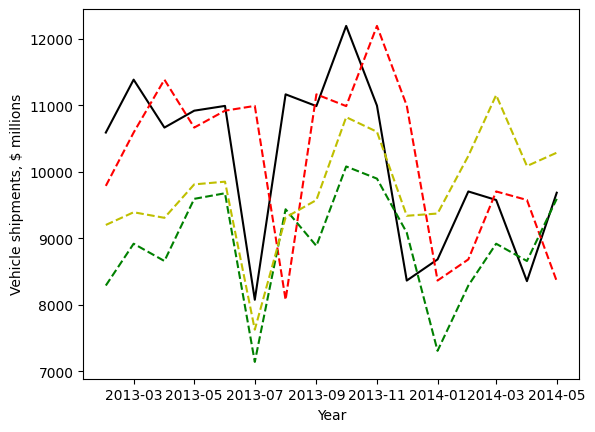

In [80]:
# !SARIMA(0,0,1)(1,1,1)12:
# Now let's do some plotting for our predictions:
# plotting the predictions (last-known, naive seasonal and SARIMA):
fig, ax = plt.subplots()
ax.plot(df['time'].values[-16:], df['value'].values[-16:], 'k')
ax.set_xlabel('Year')
ax.set_ylabel('Vehicle shipments, $ millions')
ax.plot(df['time'].values[-16:], pred_last_known[1:], 'r--')
ax.plot(df['time'].values[-16:], pred_seasonal[1:], 'g--')
ax.plot(df['time'].values[-16:], pred_SARIMA[1:], 'y--')
# we can actually see that despite one strange fluctuation in our predicition,
# our model still quite well captured the seasonal effect (at least better
# that the baseline methods).

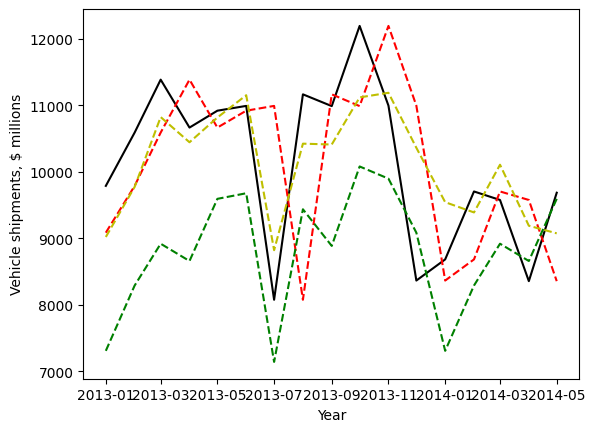

In [66]:
# !SARIMA(3,0,1)(0,1,1)12:
fig, ax = plt.subplots()
ax.plot(df['time'].values[-17:], df['value'].values[-17:], 'k')
ax.set_xlabel('Year')
ax.set_ylabel('Vehicle shipments, $ millions')
ax.plot(df['time'].values[-17:], pred_last_known, 'r--')
ax.plot(df['time'].values[-17:], pred_seasonal, 'g--')
ax.plot(df['time'].values[-17:], pred_SARIMA, 'y--')

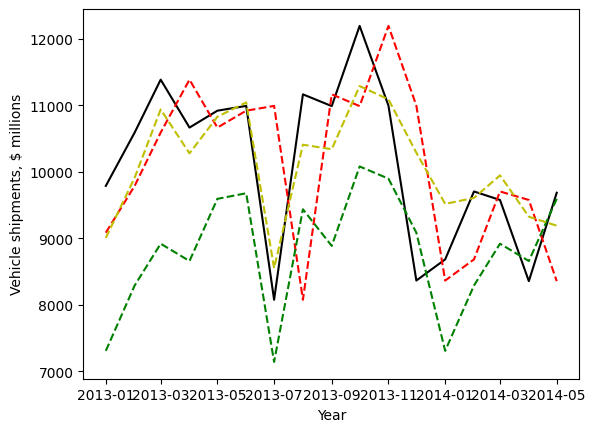

In [86]:
# !SARIMA(3,0,1)(0,1,3)12:
fig, ax = plt.subplots()
ax.plot(df['time'].values[-17:], df['value'].values[-17:], 'k')
ax.set_xlabel('Year')
ax.set_ylabel('Vehicle shipments, $ millions')
ax.plot(df['time'].values[-17:], pred_last_known, 'r--')
ax.plot(df['time'].values[-17:], pred_seasonal, 'g--')
ax.plot(df['time'].values[-17:], pred_SARIMA, 'y--')